In [2]:
# Importing libraries
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geoplot as gplt 
import geopandas as gpd
import geoplot.crs as gcrs
from shapely.geometry import Point
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [8]:
# Data cleaning

#importing datasets needed
df = pd.read_csv("../FinalDataStory/datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")
districts_df = gpd.read_file("../FinalDataStory/datasets/MO_MoDOT_Districts-20250502T153848Z-1-001/MO_MoDOT_Districts/MO_MoDOT_Districts.shp")

districts_df.head()
df.head()

#get list of columns to pick which ones i will need
col_names = df.columns.to_list()
#print(col_names)

#picking columns that i want
filtered_df = df[["OBJECTID", "STATE_CODE_001", "STRUCTURE_NUMBER_008", "COUNTY_CODE_003", "FACILITY_CARRIED_007"
                 , "LAT_016", "LONG_017", "YEAR_BUILT_027", "TRAFFIC_LANES_ON_028A", "ADT_029", "YEAR_ADT_030", 
                 "BRIDGE_IMP_COST_094", "YEAR_RECONSTRUCTED_106", "FUTURE_ADT_114", "YEAR_OF_FUTURE_ADT_115", 
                 "BRIDGE_CONDITION", "STRUCTURE_LEN_MT_049", "LOWEST_RATING", "SUPERSTRUCTURE_COND_059", "HIGHWAY_DISTRICT_002"]]

filtered_df.head()


,OBJECTID,STATE_CODE_001,STRUCTURE_NUMBER_008,COUNTY_CODE_003,FACILITY_CARRIED_007,LAT_016,LONG_017,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,YEAR_ADT_030,BRIDGE_IMP_COST_094,YEAR_RECONSTRUCTED_106,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,BRIDGE_CONDITION,STRUCTURE_LEN_MT_049,LOWEST_RATING,SUPERSTRUCTURE_COND_059,HIGHWAY_DISTRICT_002
0,290899,29,1,21,MO 6 E,39463723,94473709,1958,6,15423,2023,NaN,1992,20821,2043,F,61.6,6,7,1
1,290900,29,10,25,US 36 E,39440616,93562572,1958,4,8566,2023,NaN,2000,17989,2043,F,6.4,5,N,1
2,290901,29,100,165,IS 29 S,39273317,94471789,1958,4,36821,2023,204.0,0,75483,2043,P,6.6,4,N,3
3,290902,29,1000,77,US 60 E,37072768,93133368,1965,2,15996,2023,NaN,2009,24794,2043,F,120.4,5,5,6
4,290903,29,10000,67,MO 76 E,36581862,92254722,1940,2,419,2023,NaN,0,649,2043,F,15.5,5,5,7


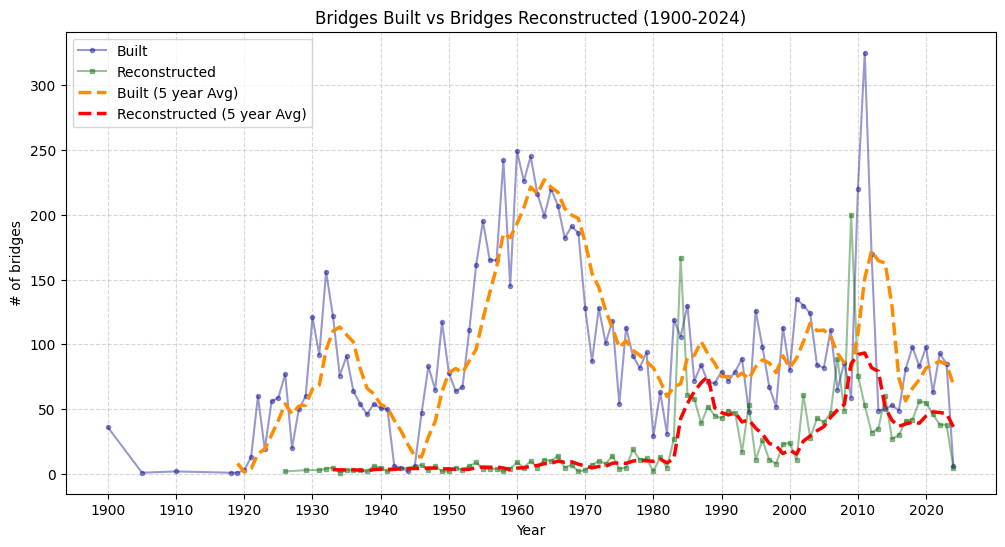

In [34]:
# Time series: Bridges built per year with bridges reconstructed per year

fig, ax = plt.subplots(figsize=(12,6))

#getting bridges and bridges reconstructed per year
bridges_per_year = filtered_df.groupby("YEAR_BUILT_027")["OBJECTID"].count()
reconst_per_year = filtered_df.groupby("YEAR_RECONSTRUCTED_106")["OBJECTID"].count()

#filtering out the first row (there are alot that have zeros = not reconstructed)
reconst_per_year = reconst_per_year.iloc[1:]
#print(reconst_per_year)

#plotting
ax.plot(bridges_per_year.index, bridges_per_year.values, marker="o", ms=3, label="Built", color="darkblue", alpha=0.4)
ax.plot(reconst_per_year.index, reconst_per_year.values, marker="s", ms=3, label="Reconstructed", color="darkgreen", alpha=0.4)

#plotting rolling avgs for each dataset to be more descriptive
bridges_built_rolling = bridges_per_year.rolling(window=5).mean()
reconst_rolling = reconst_per_year.rolling(window=5).mean()
ax.plot(bridges_built_rolling.index, bridges_built_rolling.values, label="Built (5 year Avg)", linestyle="--", color="darkorange", linewidth=2.5)
ax.plot(reconst_rolling.index, reconst_rolling.values, label="Reconstructed (5 year Avg)", linestyle="--", color="red", linewidth=2.5)

#final touches
ax.set_xticks(np.arange(1900, 2025, 10)) #doing every 10 years instead of every 20
ax.set_title("Bridges Built vs Bridges Reconstructed (1900-2024)")
ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("# of bridges")
ax.grid(True, linestyle='--', alpha=0.5)

In [9]:
districts_df.head()

,OBJECTID,DISTRICT_N,DISTRICT_1,DISTRICT_A,SE_ANNO_CA,Shape__Are,Shape__Len,geometry
0,1,1,NORTHWEST,NW,None,4.764621e+10,1.337988e+06,"POLYGON ((-10578761.024 4950037.143, -10576481..."
1,2,2,NORTHEAST,NE,None,4.049008e+10,1.121644e+06,"POLYGON ((-10206411.942 4950140.901, -10206481..."
2,3,3,KANSAS CITY,KC,None,2.428183e+10,9.276540e+05,"POLYGON ((-10549029.885 4798070.498, -10547842..."
3,4,4,CENTRAL,CD,None,4.733163e+10,1.124795e+06,"POLYGON ((-10253515.028 4737187.909, -10253573..."
4,5,5,ST. LOUIS,SL,None,1.175764e+10,6.052030e+05,"POLYGON ((-10068383.485 4716930.661, -10068278..."


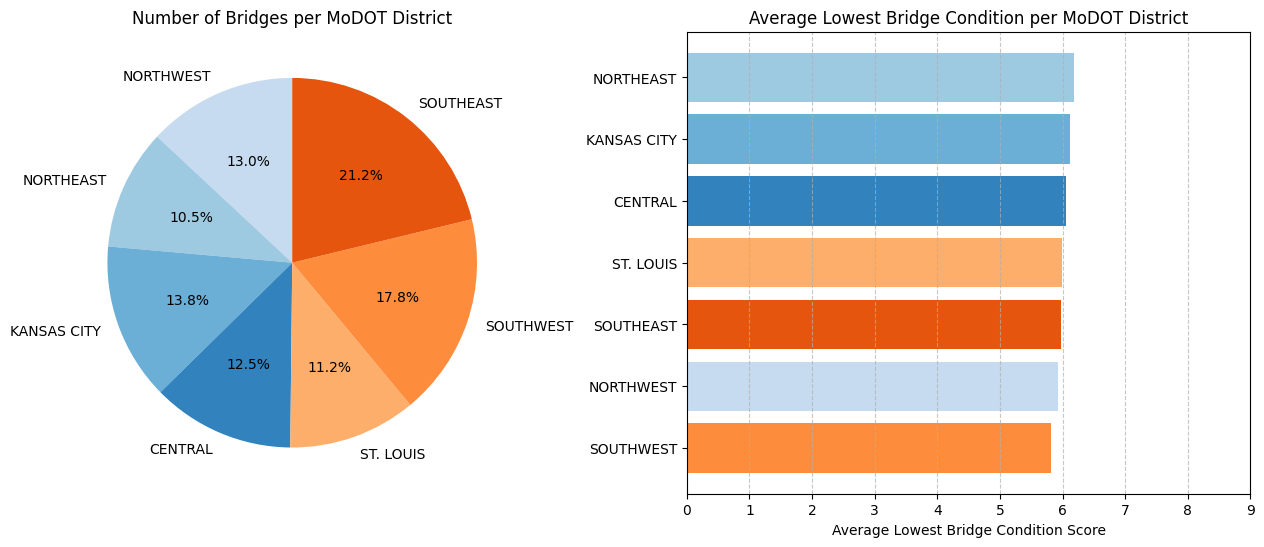

In [30]:
# Pie chart: Number of bridges per district, Condition by district

districts_df["HIGHWAY_DISTRICT_002"] = districts_df["DISTRICT_N"]

#use highway_district to get number of bridges per district 
bridges_df = pd.merge(filtered_df, districts_df, how="inner", on="HIGHWAY_DISTRICT_002")
bridges_df.head()

bridge_counts = ( #getting bridge counts for each highway district/mo district
    bridges_df.groupby(["HIGHWAY_DISTRICT_002", "DISTRICT_1"])
    .size()
    .reset_index(name="bridge_count")
)

bridge_counts.head()

#now plotting avg lowest condition rating for each district
avg_condition = (
    bridges_df.groupby(["DISTRICT_1", "HIGHWAY_DISTRICT_002"])["LOWEST_RATING"]
    .mean()
    .reset_index(name="avg_lowest_condition")
)
avg_condition = avg_condition.sort_values('avg_lowest_condition')

#getting color maps to match districts to same color for both plots
districts = bridge_counts["DISTRICT_1"].unique()
colors = plt.cm.tab20c.colors
color_map = {district: colors[i % len(colors)] for i, district in enumerate(sorted(districts))}

bridge_counts["color"] = bridge_counts["DISTRICT_1"].map(color_map)
avg_condition["color"] = avg_condition["DISTRICT_1"].map(color_map)

# # --- subplots ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#pie chart for number of bridges per missouri district
axes[0].pie(
    bridge_counts["bridge_count"],
    labels=bridge_counts["DISTRICT_1"],
    autopct="%1.1f%%",
    startangle=90,
    colors=bridge_counts["color"]
)
axes[0].set_title("Number of Bridges per MoDOT District")

#bar chart for average lowest condition per missouri district
axes[1].barh(
    avg_condition["DISTRICT_1"],
    avg_condition['avg_lowest_condition'],
    color=avg_condition["color"]
)
axes[1].set_xlabel("Average Lowest Bridge Condition Score")
axes[1].set_title("Average Lowest Bridge Condition per MoDOT District")
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].set_xlim(0,9) #setting limit to 0 to 9 to reflect codes

plt.show()


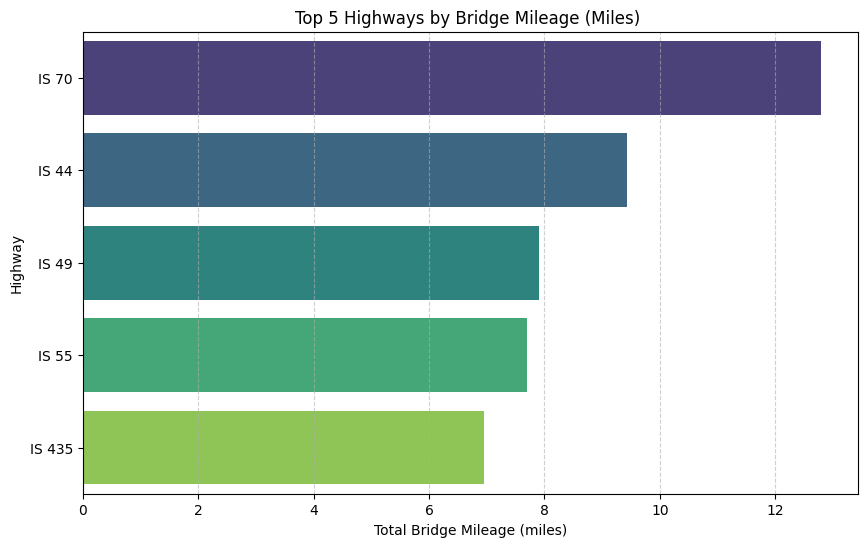

In [22]:
# Bar Chart: Top 5 highways with number of bridge mileage

filtered_for_miles = filtered_df.copy()
#stripping end of highway name to combine east and west highways
filtered_for_miles["FACILITY_CARRIED_007"] = filtered_for_miles["FACILITY_CARRIED_007"].str.replace(r'\s+[NEWS]$', '', regex=True)

filtered_for_miles['bridge_miles'] = filtered_for_miles['STRUCTURE_LEN_MT_049'] / 1609.34 #getting brdige mileage from the col that has bridge mileage in meters

#get top 5 highways based on bridge mileage
filtered_for_miles.head()
top_highways = (
    filtered_for_miles.groupby('FACILITY_CARRIED_007')['bridge_miles']
    .sum()
    .reset_index(name='total_mileage')
    .sort_values('total_mileage', ascending=False)
    .head(5)
)

top_highways.head()

plt.figure(figsize=(10, 6))
sns.barplot( #plotting with seaborn
    data=top_highways,
    x='total_mileage',
    y='FACILITY_CARRIED_007',
    palette='viridis'
)
plt.xlabel("Total Bridge Mileage (miles)")
plt.ylabel("Highway")
plt.title("Top 5 Highways by Bridge Mileage (Miles) ")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
